# 1. 이미지 준비

In [1]:
import os
import urllib
import cv2 as cv
import numpy as np
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt

* urllib는 웹에서 데이터를 다운로드할 때 사용한다.
* cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요하다.
* pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리이다..

(720, 540, 3)


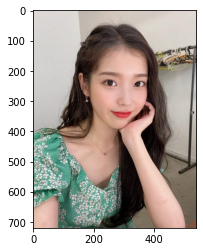

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv.imread(img_path)

print(img_orig.shape)
plt.imshow(cv.cvtColor(img_orig,cv.COLOR_BGR2RGB))
plt.show()

# 2. 세그멘테이션으로 사람 분리하기 (누끼 따기)
* 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션이라고 한다.
* 모든 픽셀에 라벨을 할당하고 같은 라벨은 공통적인 특징을 가진다고 가정한다.
* 시맨틱 세그멘테이션이란 물리적 단위로 분류하는 방법이다.( 사람, 자동차, 비행기 등으로 분류하는것) 사람이면 같은 라벨로 표현된다.
* 인스턴스 세그멘테이션이란 한 이미지에 여러사람이 있으면 사람 개개인별로 다른 라벨을 가지게한다.

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url,model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f7418d4f190>)

* 모델 준비하기

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

* 세그멘테이션 모델 생성 후 모델에 이미지를 입력함
* segmentAsPascalvoc 함수는 PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미이다.
* 모델마다 학습시킨 데이터에 따라 결과값은 달라지기때문에 어떤 데이터를 학습시켰는지 확인하는 것이 중요하다.

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

* PASCAL VOC 데이터 라벨의 종류
* background를 제외한 20개의 클래스
* 라벨 0 : background ~~ 라벨 20 : tv
* 사람의 라벨은 15이다!!

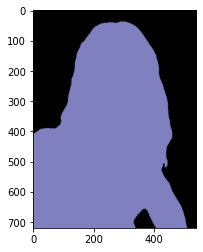

In [6]:
plt.imshow(output)
plt.show()

* output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨있다.

In [7]:
print(segvalues)

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}
background
person


*  segvalues에는 class_ids와 mask가 담겨있다
* class_ids를 통해 어떤 물체가 담겨있는지 알 수 있다.

In [8]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

* PixelLib에 따르면 위와 같은 색을 사용했다고 한다.

In [9]:
colormap[15]

array([192, 128, 128])

* 사람을 나타내는 15번째 색상
* 사람 외에 다른 물체를 찾아내고싶으면 colormap[class_id] 로 찾아낼 수 있음
* ❗주의❗ output 이미지는 BGR , colormap은 RGB순서이다.

In [10]:
seg_color=(128,128,192)

* ❗주의❗ output 이미지는 BGR , colormap은 RGB순서라서 바꿔줘야함

(720, 540)


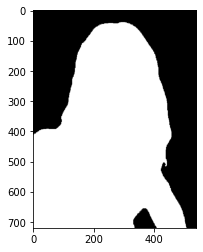

In [11]:
seg_map = np.all(output==seg_color,axis=-1)
print(seg_map.shape)
plt.imshow(seg_map,cmap='gray')
plt.show()

* np.all()은 모든 요소가 TRUE로 평가되는지 테스트하는 것이다.
* output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.

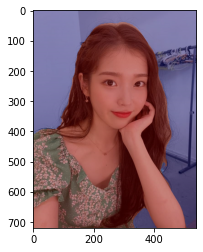

In [12]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv.applyColorMap(img_mask, cv.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

# 3. 배경 흐리게 하기

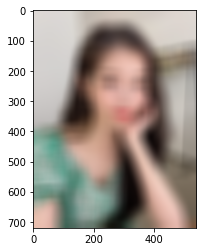

In [13]:
img_orig_blur = cv.blur(img_orig,(50,50))
plt.imshow(cv.cvtColor(img_orig_blur, cv.COLOR_BGR2RGB))
plt.show()

* (50,50) 은 blurring kernel size를 뜻한다.
* 크게 할수록 블러의 강도가 커진다.

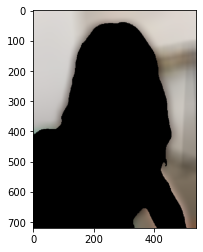

In [14]:
img_mask_color = cv.cvtColor(img_mask, cv.COLOR_GRAY2BGR)
img_bg_mask = cv.bitwise_not(img_mask_color)

img_bg_blur = cv.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv.cvtColor(img_bg_blur, cv.COLOR_BGR2RGB))
plt.show()

* bitwise_not 함수를 사용하면 이미지가 반전된다.
* 배경 0, 사람 255 ---> 배경 255, 사람 0
* 이를 통해 배경만 있는 이미지를 얻을 수 있다.

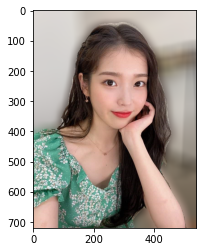

In [15]:
img_concat = np.where(img_mask_color==255,img_orig,img_bg_blur)
plt.imshow(cv.cvtColor(img_concat,cv.COLOR_BGR2RGB))
plt.show()

* 세그멘테이션 마스크가 255인 부분만 원본 이미지값을 가지고오고 아닌 영역은 블러된 이미지 값을 사용한다.
*np.where(조건, 참일때, 거짓일때)

# project
## 1. dog

(592, 594, 3)


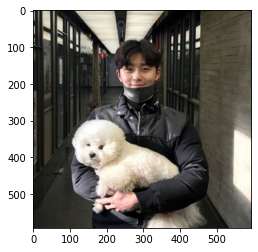

In [16]:
dog_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
dog_img_orig = cv.imread(dog_img_path)

print(dog_img_orig.shape)
plt.imshow(cv.cvtColor(dog_img_orig,cv.COLOR_BGR2RGB))
plt.show()

In [17]:
segvalues, output = model.segmentAsPascalvoc(dog_img_path)
colormap[12]

array([ 64,   0, 128])

* dog의 라벨 : 12

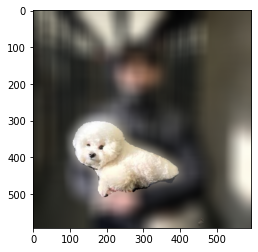

In [18]:
# output 이미지는 BGR , colormap은 RGB
seg_color=(128,0,64)

# dog - True  나머지 - False
seg_map = np.all(output==seg_color,axis=-1)

dog_img_show = dog_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
dog_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv.applyColorMap(dog_img_mask, cv.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
dog_img_show = cv.addWeighted(dog_img_show, 0.6, color_mask, 0.4, 0.0)

# 블러처리
dog_img_orig_blur = cv.blur(dog_img_orig,(50,50))

# 배경만 추출
dog_img_mask_color = cv.cvtColor(dog_img_mask, cv.COLOR_GRAY2BGR)
dog_img_bg_mask = cv.bitwise_not(dog_img_mask_color)
dog_img_bg_blur = cv.bitwise_and(dog_img_orig_blur, dog_img_bg_mask)

# 블러된 배경과 강아지 합치기
dog_img_concat = np.where(dog_img_mask_color==255,dog_img_orig,dog_img_bg_blur)
plt.imshow(cv.cvtColor(dog_img_concat,cv.COLOR_BGR2RGB))
plt.show()

## 2.car

(312, 628, 3)


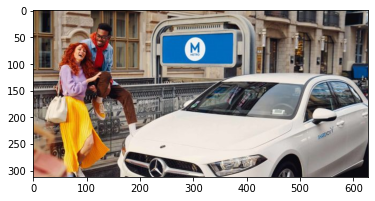

In [19]:
car_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/car.png'  
car_img_orig = cv.imread(car_img_path)

print(car_img_orig.shape)
plt.imshow(cv.cvtColor(car_img_orig,cv.COLOR_BGR2RGB))
plt.show()

In [20]:
segvalues, output = model.segmentAsPascalvoc(car_img_path)
colormap[7]

array([128, 128, 128])

* car의 라벨 : 7

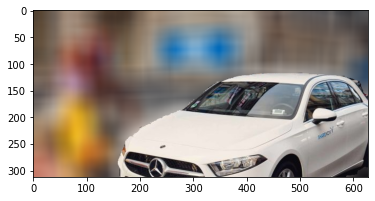

In [21]:
# output 이미지는 BGR , colormap은 RGB
seg_color=(128,128,128)

# car - True  나머지 - False
seg_map = np.all(output==seg_color,axis=-1)

car_img_show = car_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
car_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv.applyColorMap(car_img_mask, cv.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
car_img_show = cv.addWeighted(car_img_show, 0.6, color_mask, 0.4, 0.0)

# 블러처리
car_img_orig_blur = cv.blur(car_img_orig,(50,50))

# 배경만 추출
car_img_mask_color = cv.cvtColor(car_img_mask, cv.COLOR_GRAY2BGR)
car_img_bg_mask = cv.bitwise_not(car_img_mask_color)
car_img_bg_blur = cv.bitwise_and(car_img_orig_blur, car_img_bg_mask)

# 블러된 배경과 강아지 합치기
car_img_concat = np.where(car_img_mask_color==255,car_img_orig,car_img_bg_blur)
plt.imshow(cv.cvtColor(car_img_concat,cv.COLOR_BGR2RGB))
plt.show()

## 3. 크로마키
### 1) 배경이 될 이미지

(500, 750, 3)


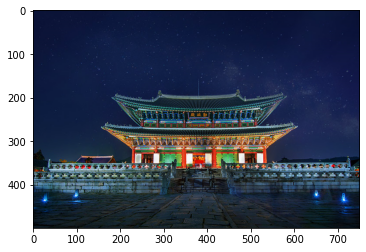

In [22]:
k_path=os.getenv('HOME')+'/aiffel/human_segmentation/images/korea.png' 
k_img_orig = cv.imread(k_path)

print(k_img_orig.shape)
plt.imshow(cv.cvtColor(k_img_orig,cv.COLOR_BGR2RGB))
plt.show()

### 2) 위에서 잘라놓은 자동차 추가

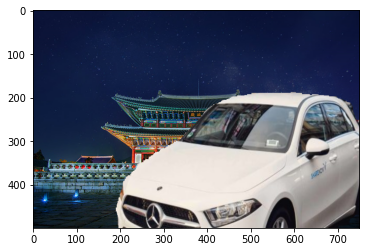

In [23]:
car_resized = cv.resize(car_img_orig, (k_img_orig.shape[1], k_img_orig.shape[0]))
car_img_mask_resized = cv.resize(car_img_mask_color, (k_img_orig.shape[1], k_img_orig.shape[0]))

# 합체
korea_car_concat = np.where(car_img_mask_resized==255,car_resized,k_img_orig)

plt.imshow(cv.cvtColor(korea_car_concat,cv.COLOR_BGR2RGB))
plt.show()

* 자동차 크기 조절

## 4. 인물사진에서 발생한 문제점

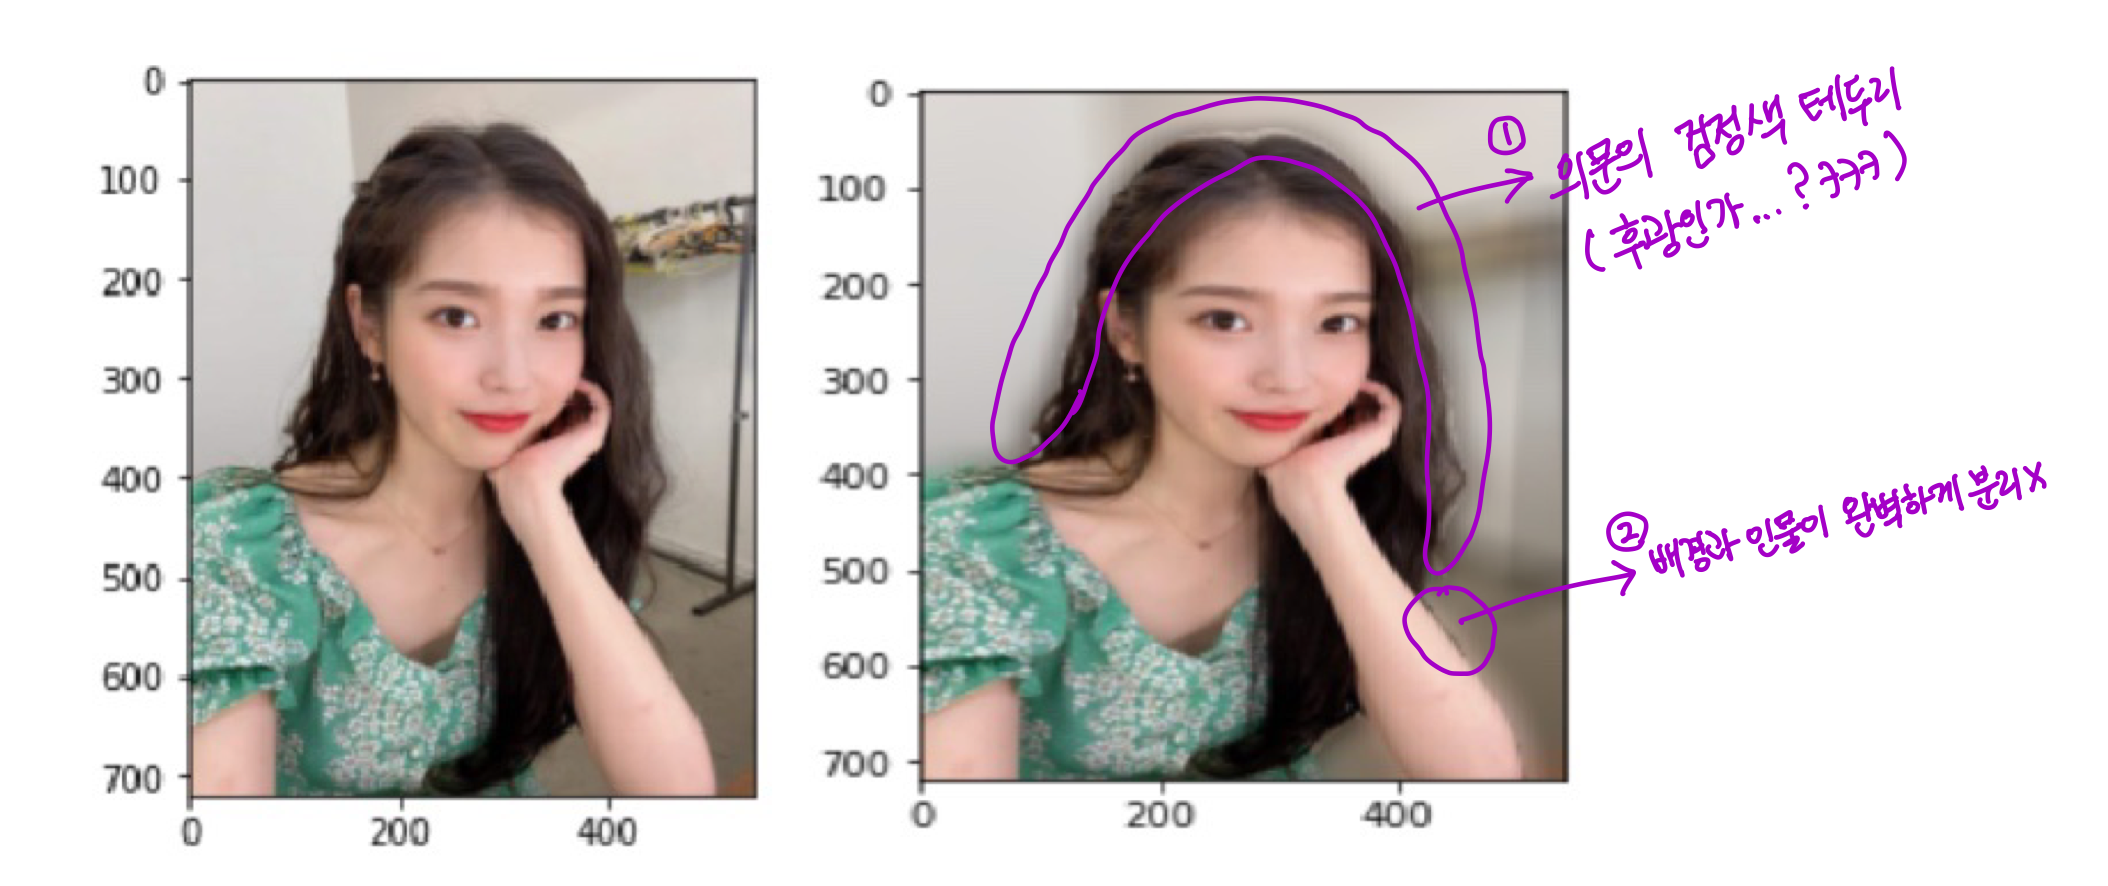

* 의문의 검정 테두리
* 배경과 인물이 완벽하게 분리가 되지않았다.

## 5. 문제점 개선
### 1) kernel size를 처음에 (50,50)으로 줬는데, 블러가 너무 강해서 문제점이 생긴걸까?

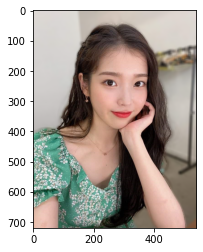

In [24]:
segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color=(128,128,192)
seg_map = np.all(output==seg_color,axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv.applyColorMap(img_mask, cv.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

img_orig_blur = cv.blur(img_orig,(10,10))

img_mask_color = cv.cvtColor(img_mask, cv.COLOR_GRAY2BGR)
img_bg_mask = cv.bitwise_not(img_mask_color)
img_bg_blur = cv.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255,img_orig,img_bg_blur)
plt.imshow(cv.cvtColor(img_concat,cv.COLOR_BGR2RGB))
plt.show()


* 커널 사이즈를 통해서 블러의 강도를 줄여주니 검정 테두리가 완화됐다

### 2) 배경과 인물이 완벽하게 분리되지않았다.

* 아주 자세하게 봐야알수있는 문제지만..인물 사진은 아니지만 자동차 사진에서도 똑같은 문제를 볼 수 있다.
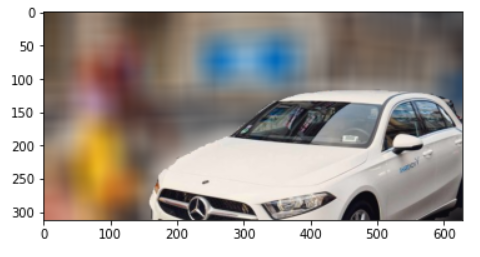
* 마스크 이미지가 0 또는 1로 극단적으로 나눠져있어서 보이는 문제이다.
* 기존 블러 말고 가우시안 블러를 사용하여 이미지를 부드럽게 처리하여 해결할 수 있을것같다.


# 회고 



## 1. project car 부분에서 오류

cv2.addweighted() , cv2.bitwise_and() 부분에서 에러

>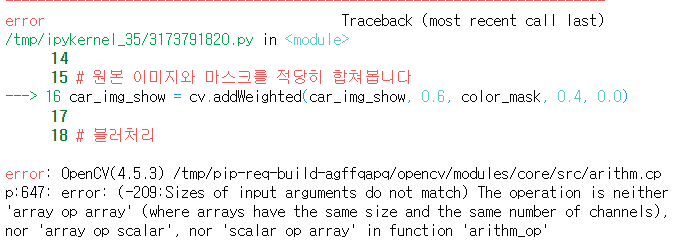



>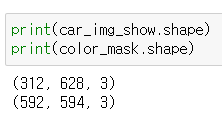

* cv2.addweighted() , cv2.bitwise_and() 는 이미지의 크기를 맞춰줘야한다고한다.shape를 찍어봤더니 다른 배열인 것을 확인


* reshape 코드 추가 : car_resized = cv.resize(car_img_orig, (color_mask.shape[1], color_mask.shape[0]))


* 배열이 6 * 4 --> 2 * 12 이렇게만 변환이 가능한 줄 알았는데 임의로 설정해줄수있다는것을 알았다. 작은 사이즈를 큰사이즈로 변환하는데 padding으로 채우는 것이 아닐까 생각해봤다.


* 근데 사실 내가 잘못짠거였따...seg_color=(128,128,128) 여기서 강아지에 썼던 코드를 써서 안됐던거였다!! 고쳐주니 원래 썼던 코드 그대로도 작동을 한다...어찌됐든 크로마키부분에서도 써야하는부분이였다.

## 2. 크로마키 부분에서 자동차 크기
자동차의 크기를 줄여서 좀 더 자연스럽게 표현하고싶었다.
떠오른 아이디어는 누끼 딴 자동차만 resize로 크기를 줄이고 그대로 배경에 합성하기였다.
>cv2.resize(src, dstSize, fx, fy, interpolation)

>입력 이미지(src), 절대 크기(dstSize), 상대 크기(fx, fy), 보간법(interpolation)

찾아내서 자동차 크기까지는 줄였는데 배경에 합성하려니 배경을 또 자동차에 맞춰서 resize하라고한다...ㅜㅜ
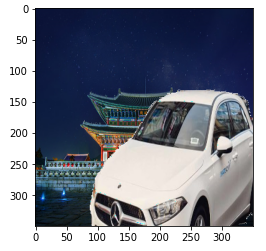
배경의 크기를 줄이니 자동차의 크기를 줄인것이 무용지물이 되어버렸다!! 이건 어떻게 하는걸까?

* openCV는 배열이 중요하구나를 느꼈다...배열,크기 관련해서 자꾸만 오류가 났다 신경써야겠다